In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from tqdm import tqdm

from sklearn import preprocessing, model_selection, ensemble, svm, metrics, feature_selection
from sklearn import dummy, model_selection, decomposition, cross_decomposition
from sklearn import multioutput

import matplotlib.pyplot as plt

In [3]:
connectivity_kinds = [
    # 'covariance',
    'correlation',
    'partial_correlation',
    'tangent',
    # 'precision'
]

In [4]:
ATLASES = [
  'dosenbach2007',
  'difumo_64_2',
  # 'difumo_128_2',
  # 'difumo_1024_2'
]

# load the datasets
DATASETS = {
  atlas: xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
  for atlas in ATLASES}

In [82]:
model = ensemble.GradientBoostingClassifier()

chance_model = dummy.DummyClassifier(strategy='uniform')

selector = feature_selection.SelectKBest(k='all')
selector = feature_selection.SelectKBest(feature_selection.f_regression)

# transformer = decomposition.PCA(n_components=5)
# transformer = UMAP(n_components=5)
transformer = cross_decomposition.PLSRegression(n_components=5)

cv = model_selection.StratifiedShuffleSplit(n_splits=100, test_size=.5)
# cv = model_selection.LeaveOneOut()

scores = []
for atlas, dataset in DATASETS.items():

    valid_beh_subjects_mask = ~np.isnan(dataset['inverse_efficiency_score_ms'].values)
    
    for kind in connectivity_kinds:
        
        # flatten connectivity matrix (and keep only upper triangle values)
        X = []
        for subj_conn in dataset[f'{kind}_connectivity'].values:
            X.append(subj_conn[np.triu_indices_from(subj_conn, k=1)])
        X = np.array(X)
        X = X[valid_beh_subjects_mask]
        
        y = preprocessing.LabelEncoder().fit_transform(dataset['group'])
        y = y[valid_beh_subjects_mask]

        y_beh = dataset['inverse_efficiency_score_ms'].values
        y_beh = y_beh[valid_beh_subjects_mask]

        X = selector.fit_transform(X, y_beh)

        X_pivoted = pd.DataFrame(X)
        X_pivoted['subject'] = X_pivoted.index.tolist()
        X_pivoted = pd.melt(X_pivoted, id_vars=['subject'], var_name='connectivity_index')
        X_pivoted['y'] = X_pivoted['subject'].apply(lambda s: y[s])
        X_pivoted['y_beh'] = X_pivoted['subject'].apply(lambda s: y_beh[s])
        
        # remap
        X = X_pivoted.drop(columns=['subject', 'y', 'y_beh'])
        X = pd.get_dummies(X, columns = ['connectivity_index']).values
        y = X_pivoted['y']
        y_beh = X_pivoted['y_beh']

        for train, test in tqdm(cv.split(X, y),
                                desc=f'{atlas} ({kind})',
                                total=cv.get_n_splits(X)):

            # feature importance
            # X_train = selector.fit_transform(X[train], y[train])
            # X_test = selector.transform(X[test])

            # dimensionality reduction
            # X_train = reducer.fit_transform(X[train], y[train])
            # X_test = reducer.transform(X[test])
            # X_train, y_train = transformer.fit_transform(X_train, y[train])
            # X_test, y_test = transformer.transform(X_test, y[test])

            # classification
            model.fit(X[train], y[train])
            chance_model.fit(X[train], y[train])

            # prediction
            y_pred = model.predict(X[test])
            y_chance = chance_model.predict(X[test])

            # evaluate
            # score = metrics.roc_auc_score(y[test], y_pred)
            score = metrics.accuracy_score(y[test], y_pred)
            # score = metrics.mean_squared_error(y_test, y_pred)
            scores.append((atlas, kind, score))

            # DEBUG chance level
            # chance_score = metrics.roc_auc_score(y[test], y_chance)
            chance_score = metrics.accuracy_score(y[test], y_chance)      
            # chance_score = metrics.mean_squared_error(y_test, y_chance)
            scores.append((atlas + '_chance', kind, chance_score))

scores = pd.DataFrame(scores, columns=['atlas', 'kind', 'score'])

# report
scores.groupby(['atlas', 'kind']).mean()

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
dosenbach2007 (correlation): 100%|██████████| 100/100 [00:04<00:00, 20.70it/s]
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
dosenbach2007 (partial_correlation): 100%|██████████| 100/100 [00:04<00:00, 22.91it/s]
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = 

score
atlas                kind                         
difumo_64_2          correlation          0.475438
                     partial_correlation  0.472250
                     tangent              0.441250
difumo_64_2_chance   correlation          0.494188
                     partial_correlation  0.502938
                     tangent              0.498062
dosenbach2007        correlation          0.464687
                     partial_correlation  0.503437
                     tangent              0.480500
dosenbach2007_chance correlation          0.498688
                     partial_correlation  0.498500
                     tangent              0.499312

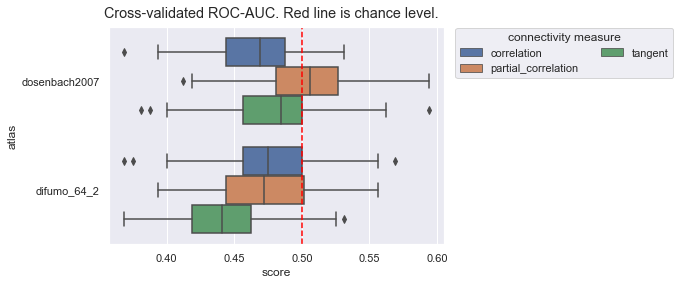

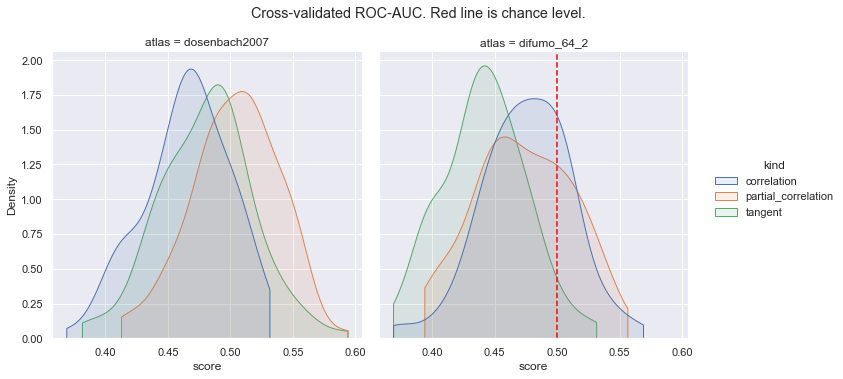

In [83]:
import pandas as pd
import seaborn as sns; sns.set()

# box/violin plot
g = sns.boxplot(data=scores.query('not atlas.str.contains("chance")'),
            y='atlas',
            x='score',
            hue='kind',
            dodge=True,
            orient='horizontal')

g.legend(loc='upper right', ncol=2, bbox_to_anchor=(1.7, 1.02), title='connectivity measure')

plt.axvline(.5, color='red', linestyle='--')

plt.suptitle('Cross-validated ROC-AUC. Red line is chance level.', y=.95)
plt.show()

# dist plot
sns.displot(
  data=scores.query('not atlas.str.contains("chance")'),
  x='score', hue='kind',
  kind='kde', col='atlas', col_wrap=2,
  clip=(0,1), cut=0,
  fill=True,  alpha=.12)

g.set(ylabel='density')

plt.suptitle('Cross-validated ROC-AUC. Red line is chance level.', y=1.05)

# # plot chance line
plt.axvline(.5, color='red', linestyle='--')

plt.show()

In [ ]:
# FIXME does not work in the new version

# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[train], y[train],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[0],
  cmap='Blues'
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[test], y[test],
  # normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[1],
  cmap='Blues'
  )

# set titles
axes[0].set(title=f'train ({len(train)} subjects)')
axes[1].set(title=f'test ({len(test)} subjects)')

plt.suptitle('Confusion matrix on one instance of train/test split')

plt.show()